## Setup imports

In [78]:
import os
import glob
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    CropForegroundd, Orientationd, Spacingd, Pad,ToTensor,Resize,DivisiblePadd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [79]:
# Define the directory containing your data
data_dir = 'C:/Users/Yugashree/Downloads/subset/debugging'

# Collect file paths
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "label", "*.nii")))

# Pair each image with its corresponding label
data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(train_images, train_labels)]

# Calculate split index for an 80/20 ratio
#split_index = int(len(data_dicts) * 0.8)

# Split data into training and validation sets
#train_files = data_dicts[:split_index]
#val_files = data_dicts[split_index:]


# Use the same data for training and validation since only one pair exists
train_files = data_dicts
val_files = data_dicts

In [124]:
from monai.transforms import ToTensor,Resize,DivisiblePadd

# Add ToTensor at the end of your transformation pipeline to ensure data is in tensor format
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    DivisiblePadd(keys=["image", "label"], k=2),
    #Resize(spatial_size=(128, 128, 80), mode='area'),  # Add Resize for image
    #Pad(keys=["image"], spatial_border=(0, 0, 1)),  # Adjust padding as needed
    ToTensor(),  # Convert both image and label to tensors
])
                         # Convert to tensor
    #CropForegroundd(keys=["image", "label"], source_key="image"),
    #Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
      # Convert to tensor after all other transformations


val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    DivisiblePadd(keys=["image", "label"], k=2),
    #Resize(spatial_size=(128, 128, 80), mode='area'),  # Add Resize for image
    #Pad(keys=["image"], spatial_border=(0, 0, 1)),  # Ensure padding is applied correctly
    ToTensor(),
])

image shape: torch.Size([128, 128, 78]), label shape: torch.Size([128, 128, 78])


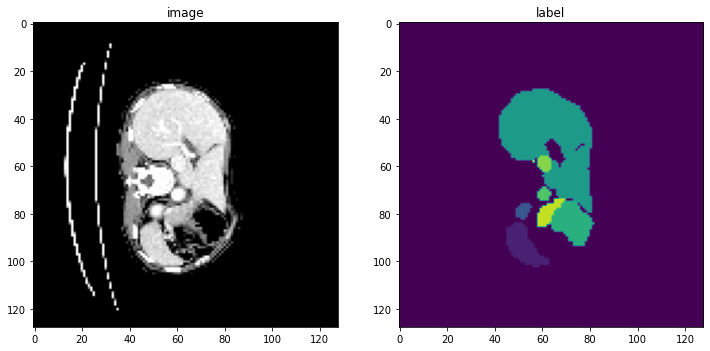

In [125]:
from monai.utils import first

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 65], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 65])
plt.show()

In [126]:
# Train and validation datasets without caching
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [127]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import DataLoader
import torch


def print_size(module, input, output):
    print(f"{module.__class__.__name__}: output size={output.size()}")
    
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model first before moving it to the device
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=15,
    channels=(16, 32, 64, 128,256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    kernel_size=3,
    up_kernel_size=3
)


# Move the model to the appropriate device (GPU or CPU)
model.to(device)

loss_function = DiceLoss(softmax=True) #to_onehot_y=True )
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [1]:
from monai.transforms import Compose, AsDiscrete

# Define your model, optimizer, and other components here...

max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

if __name__ == '__main__':
    
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        # Print the shape of the input tensor
        print_tensor_dimensions(inputs, "Input tensor")

        optimizer.zero_grad()
        outputs = model(inputs)
        print_tensor_dimensions(outputs, "Output tensor after model forward pass")
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                print_tensor_dimensions(val_inputs, "Validation input tensor")
                
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


IndentationError: expected an indented block (<ipython-input-1-89ede9e36ea8>, line 16)

In [112]:
import torch

def test_unet_dimensions():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=15,
        channels=(16, 32, 64, 128),  # Ensuring these channels double each time
        strides=(2, 2, 2),  # Standard downsampling with stride of 2
        num_res_units=2,
        norm=Norm.BATCH,
        kernel_size=3,  # This sets padding to 1 automatically in MONAI
        up_kernel_size=3  # Ensures upscaling matches downscaling
    ).to(device)

    # Use an input size that divides cleanly by 8 (2^3 downsampling operations)
    dummy_input = torch.rand(1, 1, 128, 128, 80).to(device)  # Depth adjusted to 80
    try:
        outputs = model(dummy_input)
        print("Output shape:", outputs.shape)
    except Exception as e:
        print("Error during forward pass:", e)

test_unet_dimensions()


Output shape: torch.Size([1, 15, 128, 128, 80])
